In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [63]:
dt = pd.read_csv("/kaggle/input/smp2022-duck/Gia SMP va SMPcap 2021(Gia thi truong SMP).csv", encoding='latin-1')
dt2 = np.loadtxt('/kaggle/input/smp2022-duck/Gia SMP va SMPcap 2021(Gia thi truong SMP).csv',encoding='latin-1', delimiter=',', skiprows=1, usecols=(4, 5, 6), dtype=float)

df = dt.iloc[:, [3,4,5]]  
df.columns = ['Column4', 'Column5', 'Column6']

In [64]:
print(df.describe())

           Column4      Column5      Column6
count   365.000000   365.000000   365.000000
mean   1040.229041  1040.228219  1040.228767
std     105.146791   105.147113   105.146720
min     885.700000   885.700000   885.700000
25%     988.400000   988.400000   988.400000
50%    1022.600000  1022.600000  1022.600000
75%    1061.500000  1061.500000  1061.500000
max    1565.500000  1565.500000  1565.500000


**EDA**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


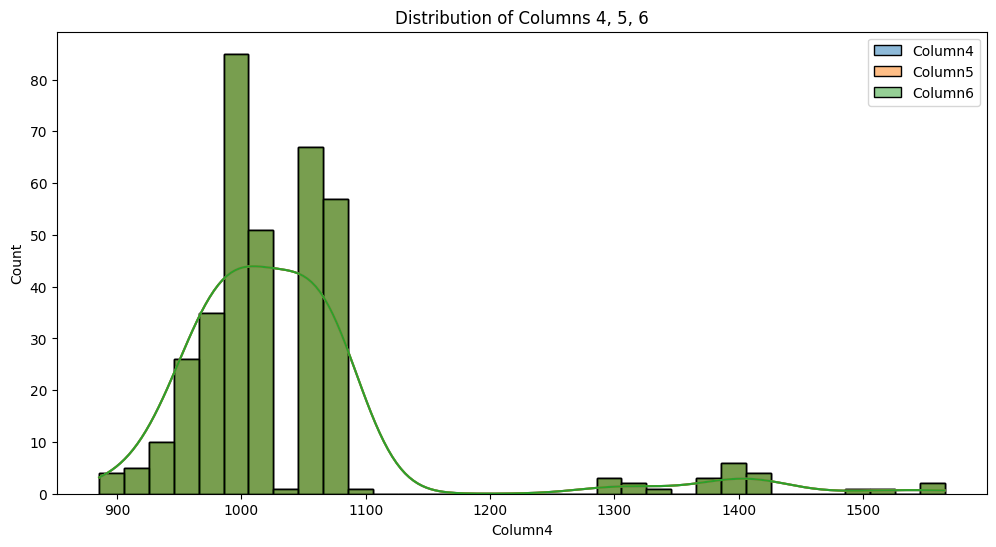

In [65]:
# biểu đồ phân phối
plt.figure(figsize=(12, 6))
sns.histplot(df['Column4'], kde=True, label='Column4')
sns.histplot(df['Column5'], kde=True, label='Column5')
sns.histplot(df['Column6'], kde=True, label='Column6')
plt.legend()
plt.title('Distribution of Columns 4, 5, 6')
plt.show()


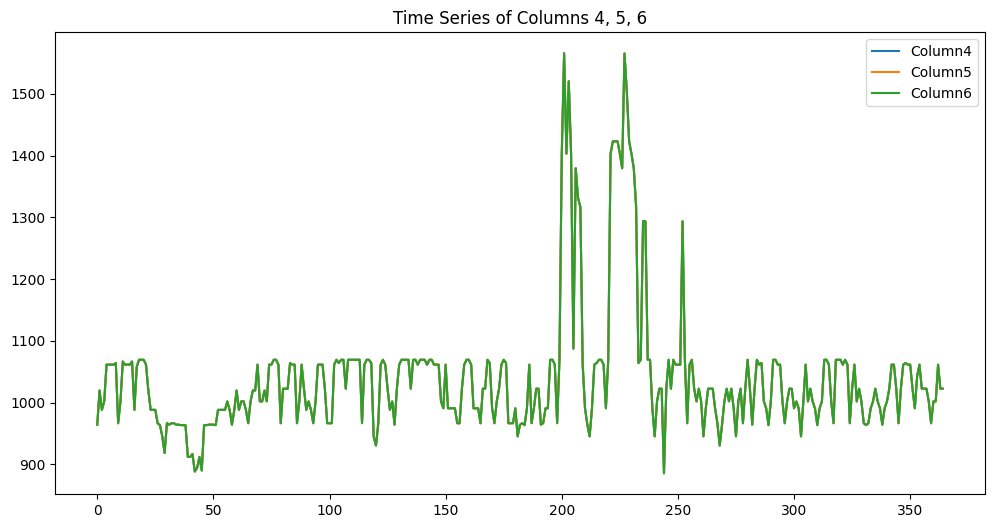

In [66]:
# biểu đồ thời gian
plt.figure(figsize=(12, 6))
plt.plot(df['Column4'], label='Column4')
plt.plot(df['Column5'], label='Column5')
plt.plot(df['Column6'], label='Column6')
plt.legend()
plt.title('Time Series of Columns 4, 5, 6')
plt.show()


**Kalman Model**

In [67]:

x = np.zeros((3, 1))  


P = np.eye(3)


F = np.eye(3)

H = np.eye(3)


Q = np.eye(3) * 0.01


R = np.eye(3) * 0.1


z = np.zeros((3, 1))


In [68]:
def predict(x, P, F, Q):
    # Dự đoán trạng thái tiếp theo
    x = np.dot(F, x)
    P = np.dot(F, np.dot(P, F.T)) + Q
    return x, P

def update(x, P, z, H, R):
    # Tính toán các giá trị Kalman Gain
    y = z - np.dot(H, x)
    S = np.dot(H, np.dot(P, H.T)) + R
    K = np.dot(P, np.dot(H.T, np.linalg.inv(S)))

    # Cập nhật trạng thái và hiệp phương sai
    x = x + np.dot(K, y)
    P = P - np.dot(K, np.dot(H, P))
    return x, P


In [69]:
filtered_dt2 = []

for measurement in dt2:
    z = measurement.reshape(3, 1)  
   
    x, P = predict(x, P, F, Q)

    x, P = update(x, P, z, H, R)

    filtered_dt2.append(x.flatten())

filtered_dt2 = np.array(filtered_dt2)


In [70]:
print(filtered_dt2)


[[ 877.51711712  877.51711712  877.51711712]
 [ 948.95907665  948.95907665  948.95907665]
 [ 963.78734581  963.78734581  963.78734581]
 ...
 [1020.03040875 1020.03041047 1020.03041032]
 [1020.72459979 1020.72460105 1020.72460093]
 [1021.2312508  1021.23125172 1021.23125164]]


In [71]:
mse_kalman = mean_squared_error(dt2, filtered_dt2)
mae_kalman = mean_absolute_error(dt2, filtered_dt2)
rmse_kalman = np.sqrt(mse_kalman)

print("Kalman Filter - MSE:", mse_kalman)
print("Kalman Filter - MAE:", mae_kalman)
print("Kalman Filter - RMSE:", rmse_kalman)

Kalman Filter - MSE: 2793.9652844359275
Kalman Filter - MAE: 32.38954643467299
Kalman Filter - RMSE: 52.85797276131508


**SARIMA**

In [72]:
series = dt.iloc[:, 5]

# Điền giá trị thiếu bằng phương pháp nội suy (interpolation)
series = series.interpolate(method='linear')
order = (1, 1, 1)         
seasonal_order = (1, 1, 1, 12)  

# Xây dựng và huấn luyện mô hình SARIMA
model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# In kết quả huấn luyện
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  5   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1966.078
Date:                            Tue, 21 May 2024   AIC                           3942.155
Time:                                    02:37:39   BIC                           3961.473
Sample:                                         0   HQIC                          3949.843
                                            - 365                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9983      7.544      0.132      0.895     -13.788      15.785
ma.L1         -0.9992     15.760   

SARIMA - MSE: 7106.311108386426
SARIMA - MAE: 43.2644961771728
SARIMA - RMSE: 84.29893895172363


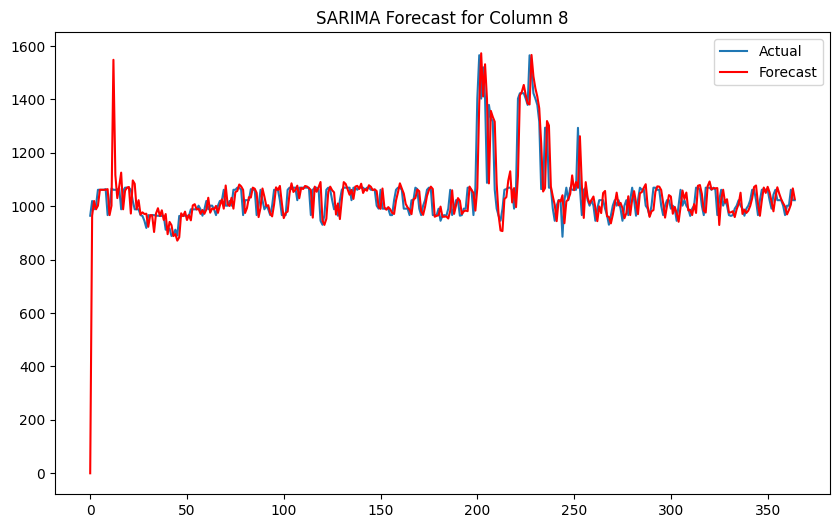

In [73]:


# Dự đoán giá trị
n_forecast = len(series)
forecast = model_fit.predict(start=0, end=n_forecast-1)

# Tính toán độ đo lỗi
mse = mean_squared_error(series, forecast)
mae = mean_absolute_error(series, forecast)
rmse = np.sqrt(mse)

print("SARIMA - MSE:", mse)
print("SARIMA - MAE:", mae)
print("SARIMA - RMSE:", rmse)

# Vẽ biểu đồ kết quả dự đoán
plt.figure(figsize=(10, 6))
plt.plot(series, label='Actual')
plt.plot(forecast, label='Forecast', color='red')
plt.title('SARIMA Forecast for Column 8')
plt.legend()
plt.show()
